# Capstone Project: 
## Using Foursquare-data to determine the success of a new burger-restaurant in a particular neighbourhood 

<img src="https://solution-selling-training.com/wp-content/uploads/2015/11/success-failure-man-succeeding1.jpg" alt="Drawing" style="width: 200px;"/>


### Business Understanding
The goal project is to determine if a burger restaurant will become __successful__ in a __particular neighbourhood__ .  
A restaurant can be described by the following characteristics: opening-hours, price, parking, wi-Fi, payment, wheelchair accessible, etc.

<em>The question is can we use one ore more of these characteristics to predict the success of a restaurant in a neighbourhood?</em>

### Data Understanding
First of all we need to get to collect data about existing restaurants for a particular neighbourhood.
Luckily the Foursquare location API provides us with this information.

The Foursquare Location API provides an endpoint to search for venues at neighbourhood.  
`GET https://api.foursquare.com/v2/venues/search`


In [3]:
# import some libraries to get the data from the Foursquare API.
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files
import seaborn as sns # libray to plot
import matplotlib.pylab as plt

In order to connect with the Foursquare API we need client-credentials.

In [4]:
CLIENT_ID = '3YFI5TCENYNDK2SHXGEPBVFEEJNLXRPGXD024KVSUHUEOMB0' # your Foursquare ID
CLIENT_SECRET = '2ODNQEIXVMPDZWPLFCIIKEOTYWKHK3GDFCE1JJJOMADEOPS3' # your Foursquare Secret
VERSION = '20190425' # Foursquare API version

We prepare the url where we filter on NEIGHBOURHOOD, RAIDUS AND CATEGORY_ID.  
A list of categories can be found [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/).

In [5]:
NEIGHBOURHOOD="New York"
RADIUS=50000 #radius in meters
LIMIT=50
CATEGORY_ID = '4bf58dd8d48988d16c941735' # let's filter on Burger joints
searchURL= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&radius={}&near={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, RADIUS, NEIGHBOURHOOD, CATEGORY_ID, LIMIT) # define URL

Now we fetch all the venues located New York

In [6]:
results = requests.get(searchURL).json()

Lets print the first 5 restaurants to see if we received the correct data

In [7]:
venues = results['response']['venues']
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head(5)

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id
0,40e74880f964a520150a1fe3,Shake Shack,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",v-1589878253,False,Southeast corner of Madison Square Park,Madison Ave & E 23rd St,40.741484,-73.988218,"[{'label': 'display', 'lat': 40.74148371088094...",...,NY,United States,[Southeast corner of Madison Square Park (Madi...,698246,https://www.seamless.com/menu/shake-shack-23rd...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN
1,5dcc4f94d4b62c0009df23dd,Emmy Squared,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1589878253,False,1426 3rd Ave,81st St.,40.775582,-73.956576,"[{'label': 'display', 'lat': 40.775582, 'lng':...",...,NY,United States,"[1426 3rd Ave (81st St.), New York, NY 10028, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59133be8e2ead1422cf975bc,Burger Village,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",v-1589878253,False,NaN,NaN,40.772611,-73.530310,"[{'label': 'display', 'lat': 40.77261116515414...",...,NY,United States,"[Hicksville, NY 11801, United States]",420244,https://www.seamless.com/menu/burger-village-2...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN
3,5655e006498ed8fc704e574d,Dark Side of the Moo,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",v-1589878253,False,52 Bowers St,NaN,40.746059,-74.044582,"[{'label': 'display', 'lat': 40.74605862371786...",...,NJ,United States,"[52 Bowers St, Jersey City, NJ 07307, United S...",322648,https://www.grubhub.com/restaurant/dark-side-o...,grubhub,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_grubhub_20180129.png,202994527
4,54bc2c76498e852a0330576d,The Committed Pig,"[{'id': '4bf58dd8d48988d16c941735', 'name': 'B...",v-1589878253,False,28 W Park Pl,Route 202,40.796839,-74.481776,"[{'label': 'display', 'lat': 40.79683914555856...",...,NJ,United States,"[28 W Park Pl (Route 202), Morristown, NJ 0796...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Now we need to find the detailed information for each venue.
In order to retrieve the detailed information about a venue we need it's ID. 
Once we have the ID, we can retrieve its details.

`GET https://api.foursquare.com/v2/venues/VENUE_ID`


First we need a list of ID's for each venue

In [8]:
venue_ids = list(nearby_venues['id'])

For each venue id, we collect the details and merge all this information into 1 dataframe

In [9]:
def getDetails(ids):
    venues_detail_frames = []
    
    for ID in ids:
        getDetailsURL= 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(ID,CLIENT_ID, CLIENT_SECRET, VERSION) # define URL
        try:
            result = requests.get(getDetailsURL).json()
            venue_details = json_normalize(result['response']) # flatten JSON
            venues_detail_frames.append(venue_details)
        except:
          print("Something went wrong")
        
    return venues_detail_frames

venues_detail_frames = getDetails(venue_ids)

Rename some the collumns this is due to the flattening operation.

In [10]:
result = pd.concat(venues_detail_frames)
filterd_columns = ['venue.id','venue.rating', 'venue.attributes.groups']
filtered_result = result[filterd_columns]

#rename collumns
for column in filtered_result.columns:
    filtered_result.rename(columns={column: column.split('.')[-1]}, inplace=True)

filtered_result.head(5)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,rating,groups
0,40e74880f964a520150a1fe3,9.2,"[{'type': 'price', 'name': 'Price', 'summary':..."
0,5dcc4f94d4b62c0009df23dd,8.6,"[{'type': 'price', 'name': 'Price', 'summary':..."
0,59133be8e2ead1422cf975bc,8.7,"[{'type': 'price', 'name': 'Price', 'summary':..."
0,5655e006498ed8fc704e574d,8.9,"[{'type': 'price', 'name': 'Price', 'summary':..."
0,54bc2c76498e852a0330576d,8.6,"[{'type': 'price', 'name': 'Price', 'summary':..."


## Data Preparation 
Now that we have collected the data we must transform it into a useable subset and verify if we need more data.
After this verification, we can check the data for questionable, missing or ambiguous case.

### Data extraction

After investigation the data we can see that a lot of data is hidden in the 'groups' column.
For each row in our dataframe we will extract the attributes in the 'groups' column.
After extraction we will join the extracted attributes with the existing dataframe.

In [11]:
# we extract the price attribute
def extractAttributes(row):
    id = row['id']
    df = pd.DataFrame(data={'id': [id]})
    for group in row['groups']:
        for item in group['items']:
             tmp = pd.DataFrame(data={item['displayName']: [item['displayValue']], 'id': [id]})
             df = df.join(tmp.set_index('id'), on='id')
    return df.iloc[0]
        
# start by dropping all the rows that don't have a rating
filtered_result.dropna(subset=['rating'], inplace=True)
    
extracted_df = filtered_result.apply(extractAttributes, axis=1)
joined_df = filtered_result.join(extracted_df.set_index('id'), on='id')
# drop unused collumns
attributes_df = joined_df.drop(['groups', 'id'], axis=1)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [12]:
attributes_df.shape

(50, 31)

We notice that some columns have a lot of NaN values. Let's investigate:

In [13]:
# lets sort the the column by the amount of NA
sorted_columns = attributes_df.isna().sum().sort_values(axis='index')
print(sorted_columns.head(10))

rating              0
Price               0
Lunch               2
Dinner              2
Outdoor Seating     4
Reservations        6
Credit Cards        7
Delivery            7
Brunch             16
Beer               21
dtype: int64


Lets use the top 10 columns who have the least missing values

In [14]:
num_features = 10
if num_features > len(sorted_columns):
    num_features = len(sorted_columns)

filter_collumns2=sorted_columns.index[0:num_features]
attributes_filtered_df = attributes_df[filter_collumns2]

### Note: we add some extra data since the data that we received from Foursquare is to small to perform an appropriate analysis 

In [15]:
import random
ratings = []
outdoor_seatings = []
for i in range(0, 20):
    ratings.append(random.randint(0, 5))
    outdoor_seatings.append('No')

mockData = pd.DataFrame({"rating":ratings, 
                         "Outdoor Seating":outdoor_seatings})
attributes_filtered_df = attributes_filtered_df.append(mockData)

Lets have a look at the different collumns and try to improve the data quality

In [16]:
# lets drop all the samples that don't have price
high_freq_price = attributes_filtered_df['Price'].value_counts().index[0] # find the price that occurs the most 
attributes_filtered_df['Price'].fillna(high_freq_price, inplace=True)
# Since we are dealing with mostly binary categorical data, we can asume that if its NaN, we can safely convert to a 'No'
attributes_filtered_df.fillna('No', inplace=True)

# Lets convert some values to yes and no answers
attributes_filtered_df = attributes_filtered_df.replace(r'\$\$\$\$', 'Very High', regex=True)
attributes_filtered_df = attributes_filtered_df.replace(r'\$\$\$', 'High', regex=True)
attributes_filtered_df = attributes_filtered_df.replace(r'\$\$', 'Medium', regex=True)
attributes_filtered_df = attributes_filtered_df.replace(r'\$', 'Low', regex=True)

attributes_filtered_df = attributes_filtered_df.replace(r'^.*Yes.*.', 'Yes', regex=True)
attributes_filtered_df = attributes_filtered_df.replace(r'Free', 'Yes', regex=True)
attributes_filtered_df = attributes_filtered_df.replace(r'^.*No.*.', 'No', regex=True)
df = attributes_filtered_df # use df because it easier to type everytime
df.shape

(70, 10)

### Data Exploration
We will show some visual representations to show the relationship between multiple variables in our dataset.

#### Visualise the data

##### Price and rating

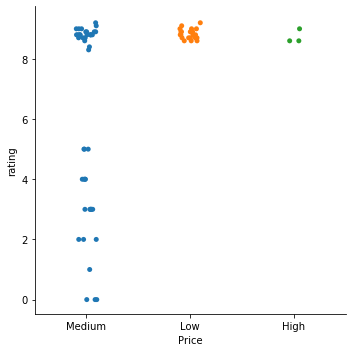

In [17]:
g = sns.catplot(x="Price", y="rating", data=df)

We notice that restaurants with a low price tag collect the full range of ratings.
Besides that we also notice that restaurants that charge 'very high' always received positive feedback.

##### Outdoor Seating and rating

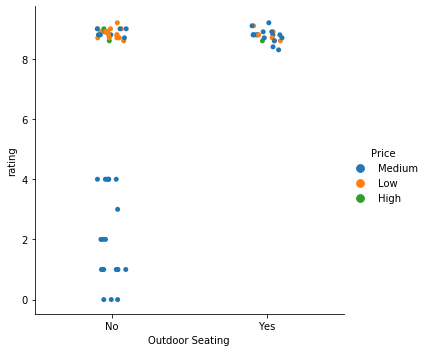

In [55]:
sns.catplot(x="Outdoor Seating", y="rating", hue="Price", data=df, order=["No", "Yes"],);

We notice that restaurants offering outdoor seating will mostly result in a higher rating

##### Boxplot of rating

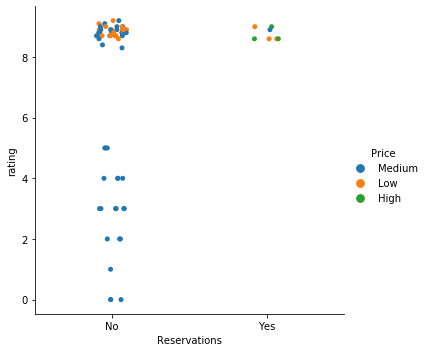

In [18]:
sns.catplot(x="Reservations", y="rating", hue="Price", data=df, order=["No", "Yes"],);

Lets have a look at the distrubtion of the ratings

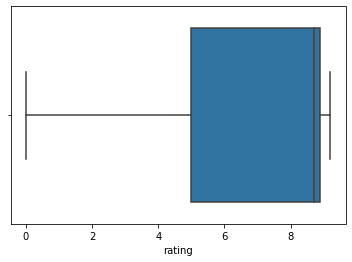

In [19]:
sns.boxplot(x=df["rating"] )

We notice some that we have several outliers less than 4/2 times of the lower quartile.
And that the Median is approximately 8.25

### Feature Engineering on Categorical Data
Turning categorical variables into quantitive variables in Python

In [20]:
# except the first column everything value contains categorical data so we apply the One hot encoding to it 
transformed_df = pd.get_dummies(df, columns=filter_collumns2[1:], prefix=filter_collumns2[1:])

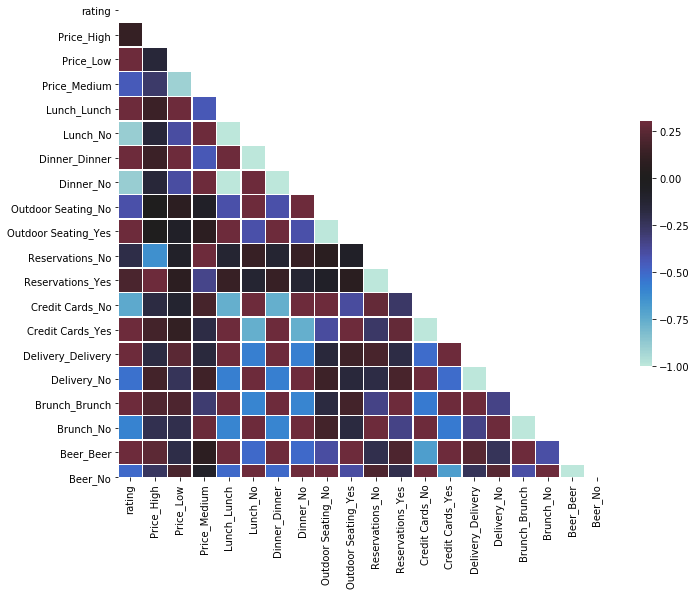

In [21]:
# Compute the correlation matrix
corr = transformed_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

We notice that the Delivery_No has a strong negative correlation regarding the dependent variable

Lets use Pearson Correlation method to verify the strength of this correlation.

In [22]:
from scipy import stats
for column in transformed_df.columns:
    pearson_coef, p_value = stats.pearsonr(transformed_df[column], transformed_df['rating'])
    print('Result for {}, coef: {}, p-value:{}'.format(column, pearson_coef, p_value) )

Result for rating, coef: 1.0, p-value:0.0
Result for Price_High, coef: 0.12156288047403808, p-value:0.31611235441073365
Result for Price_Low, coef: 0.41233748566486883, p-value:0.00038972081173792696
Result for Price_Medium, coef: -0.45087578461749683, p-value:8.96600687372047e-05
Result for Lunch_Lunch, coef: 0.8896265375376349, p-value:7.716900117229984e-25
Result for Lunch_No, coef: -0.8896265375376349, p-value:7.716900117229984e-25
Result for Dinner_Dinner, coef: 0.8896265375376349, p-value:7.716900117229984e-25
Result for Dinner_No, coef: -0.8896265375376349, p-value:7.716900117229984e-25
Result for Outdoor Seating_No, coef: -0.41077580018164506, p-value:0.0004121354585010811
Result for Outdoor Seating_Yes, coef: 0.41077580018164506, p-value:0.0004121354585010811
Result for Reservations_No, coef: -0.19428117847944074, p-value:0.1070485650879935
Result for Reservations_Yes, coef: 0.19428117847944074, p-value:0.1070485650879935
Result for Credit Cards_No, coef: -0.7404549699254753, 

### Create Training and Test Sets and apply scaling

In [23]:
X = transformed_df[['Credit Cards_Yes','Lunch_Lunch', 'Dinner_Dinner']]
y = transformed_df['rating']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Model development

In [24]:
from sklearn.linear_model import LinearRegression
# fit a model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
y_pred

array([8.5484973 , 8.5484973 , 8.5484973 , 8.5484973 , 2.14449776,
       8.5484973 , 6.50753588, 8.5484973 , 8.5484973 , 8.5484973 ,
       8.5484973 , 8.5484973 , 2.14449776, 6.50753588, 2.14449776,
       8.5484973 , 2.14449776, 8.5484973 , 2.14449776, 8.5484973 ,
       6.50753588, 8.5484973 , 6.50753588, 6.50753588])

#### Lets compare the predictions with the True Values


Text(0, 0.5, 'Predictions')

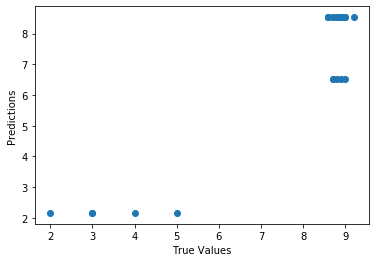

In [25]:
## The line / model
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### In-sample evaluation of our model
Return the coefficient of determination R^2 of the prediction.

In [26]:
print('Score with Training data:', model.score(X_train, y_train)) 
print('Score with Test data:', model.score(X_test, y_test)) 

Score with Training data: 0.7673053161200108
Score with Test data: 0.6610470269609283


We can say that 74% of the ratings can be explained by this multiple linear model for the test data.